## 네이버 검색어 트렌드

##### 패키지 참조

In [2]:
import requests
import json
from pandas import DataFrame, to_datetime

import sys
sys.path.append("../../")

import datetime as dt
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb
from helper import set_datetime_index, exp_time_data

## 02. 네이버 검색어 트렌드 OpenAPI 연동
### 접속에 필요한 정보 설정
#### API URL


In [3]:
API_URL = "https://openapi.naver.com/v1/datalab/search"

In [4]:
client_id = "sNbt9TXmxIhzvKuTm7_s"
client_secret = "fdgWacl2JY"

In [5]:
session  = requests.Session()
session.headers.update({
    "X-Naver-Client-Id": client_id,
    "X-Naver-Client-secret":client_secret
})

### HTTP 접속 방법 종류

#### HTTP GET 방식인 경우

```python
session.get(API_URL, params={"a": 100, "b":200})
```

#### HTTP POST 방식인 경우

```python
session.post(API_URL, data= {"a":100, "b": 200})
```

#### HTTP POST 방식이면서 파라미터를 JSON 형식으로 구성하는 경우(body data 전송)

```python
session.post(API_URL, data=json.dumps({"a":100,"b":200}))
```

In [6]:
data = {
    "startDate" : "2023-01-01",                 # 2016년 1월 1일부터 조회 시작 가능
    "endDate" : "2023-07-31",
    "timeUnit" : "date",                          # date: 일간, week: 주간, month: 월간
    "keywordGroups" : [
        {
            "groupName": "리튬",            # 검색주제
            "keywords": ["전기차", "배터리", "에코 프로"]  # 주제와 관련된 검색어
        }, # results의 0번째 
         {
            "groupName": "애플",            # 검색주제
            "keywords": ["아이폰", "비전 pro", "아이패드"]  # 주제와 관련된 검색어
        } # results의 1번째
    ]

}

In [14]:
r = session.post(API_URL, data=json.dumps(data))

if r.status_code != 200:
    msg = "[$d Error] %s 에러가 발생함"  %(r.status_code, r.reason)
    raise Exception(msg)

r.encoding = "utf-8"
mydict = json.loads(r.text)
mydict

{'startDate': '2023-01-01',
 'endDate': '2023-07-31',
 'timeUnit': 'date',
 'results': [{'title': '리튬',
   'keywords': ['전기차', '배터리', '에코 프로'],
   'data': [{'period': '2023-01-01', 'ratio': 0.77403},
    {'period': '2023-01-02', 'ratio': 2.61068},
    {'period': '2023-01-03', 'ratio': 2.69752},
    {'period': '2023-01-04', 'ratio': 2.4894},
    {'period': '2023-01-05', 'ratio': 2.2216},
    {'period': '2023-01-06', 'ratio': 2.18593},
    {'period': '2023-01-07', 'ratio': 0.84168},
    {'period': '2023-01-08', 'ratio': 0.84685},
    {'period': '2023-01-09', 'ratio': 2.32807},
    {'period': '2023-01-10', 'ratio': 2.28426},
    {'period': '2023-01-11', 'ratio': 2.70532},
    {'period': '2023-01-12', 'ratio': 2.44812},
    {'period': '2023-01-13', 'ratio': 2.13362},
    {'period': '2023-01-14', 'ratio': 0.81645},
    {'period': '2023-01-15', 'ratio': 0.81759},
    {'period': '2023-01-16', 'ratio': 2.32132},
    {'period': '2023-01-17', 'ratio': 2.20364},
    {'period': '2023-01-18', 'rati

#### 가져온 결과를 데이터프레임으로 변환

In [8]:
df = DataFrame(mydict['results'][0]['data'])
df

,period,ratio
0,2023-01-01,0.77403
1,2023-01-02,2.61068
2,2023-01-03,2.69752
3,2023-01-04,2.48940
4,2023-01-05,2.22160
...,...,...
207,2023-07-27,95.25823
208,2023-07-28,71.91963
209,2023-07-29,9.31563
210,2023-07-30,6.35775


## 03. 연동 결과에 대한 시계열 분석
### 데이터 타입 확인


In [9]:
df.dtypes

period     object
ratio     float64
dtype: object

#### 날짜 컬럼에 대한 형변환 및 인덱스 설정

In [10]:
df['period'] = to_datetime(df['period'])
df2 = set_datetime_index(df,'period')
df2

,ratio
2023-01-01,0.77403
2023-01-02,2.61068
2023-01-03,2.69752
2023-01-04,2.48940
2023-01-05,2.22160
...,...
2023-07-27,95.25823
2023-07-28,71.91963
2023-07-29,9.31563
2023-07-30,6.35775


결측치 수: 0


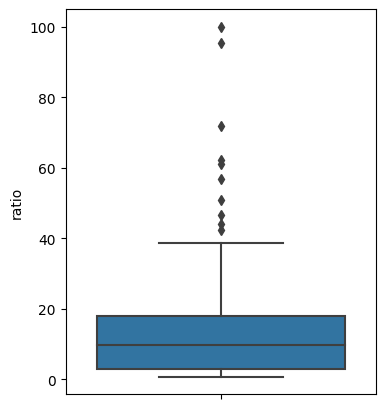

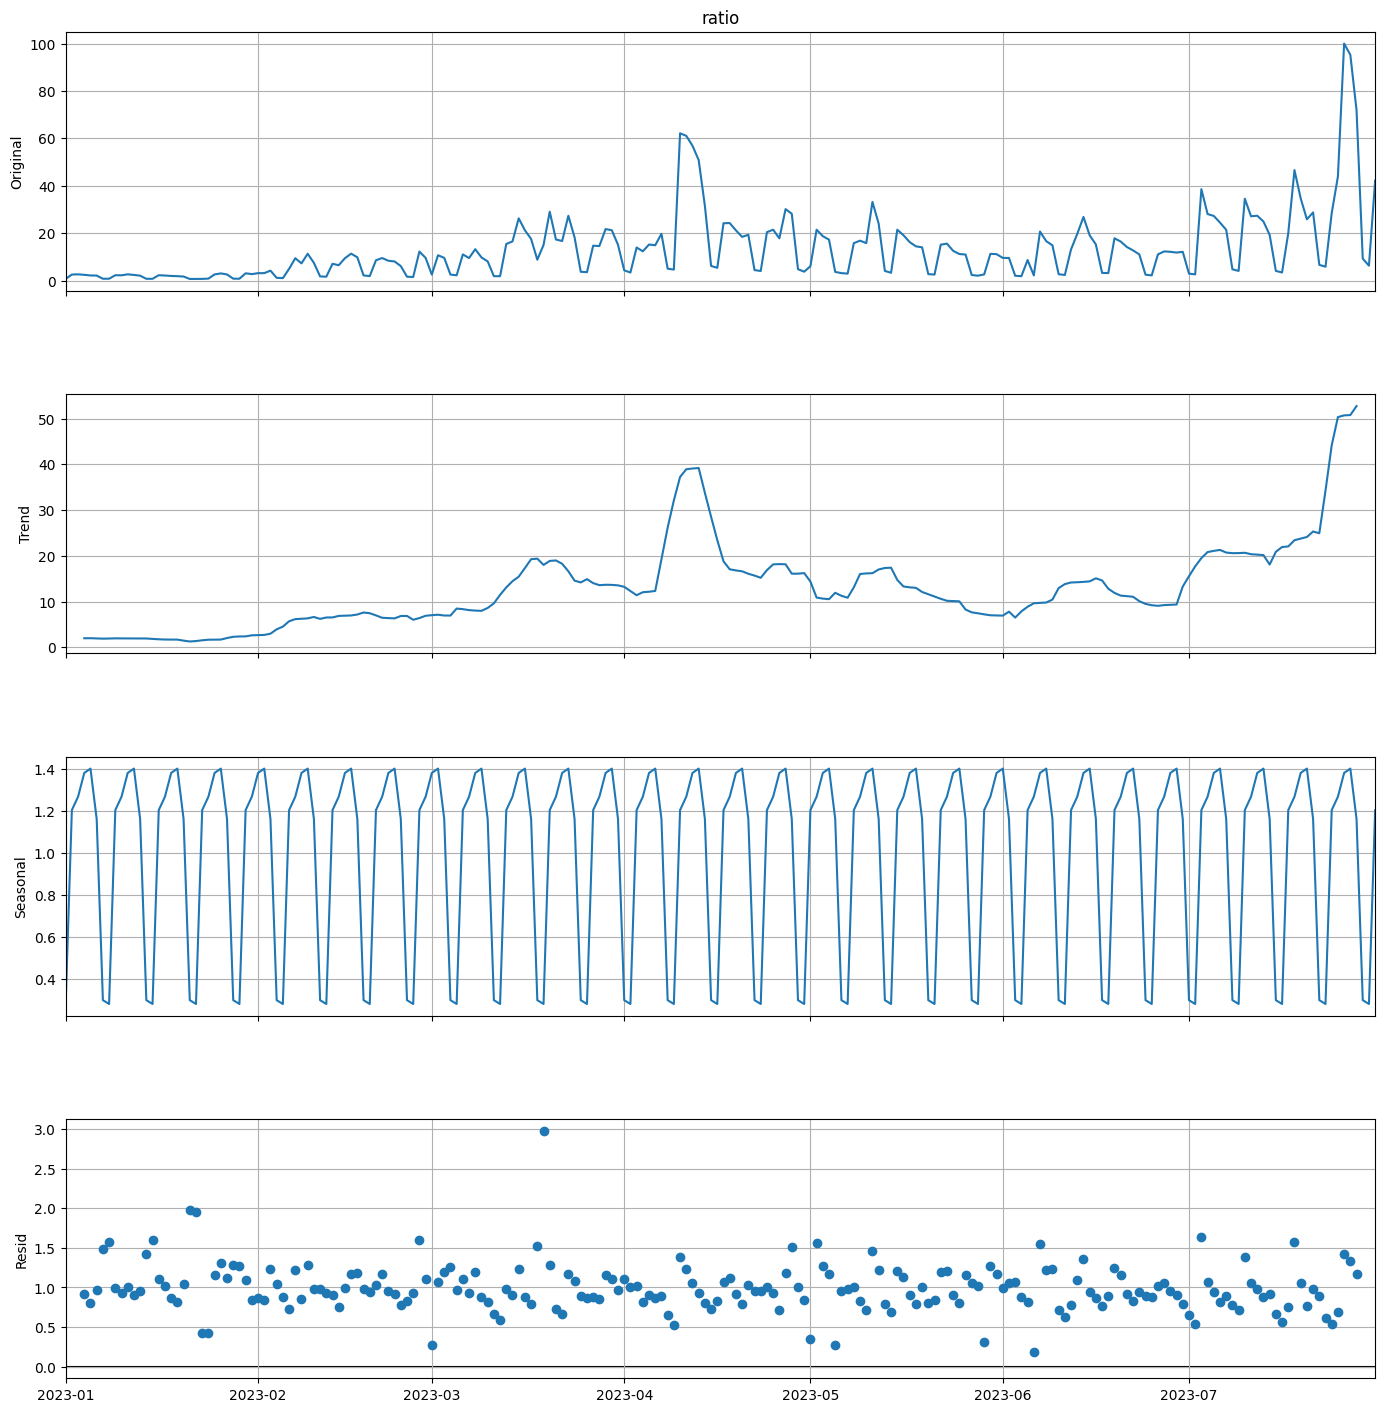

=========== 원본 데이터 ===========
+------------------------------------+-----------+
| ADF Test                           |           |
|------------------------------------+-----------|
| 검정통계량(ADF Statistic)          | -0.253559 |
| 유의수준(p-value)                  |  0.931829 |
| 최적차수(num of lags)              |        14 |
| 관측치 개수(num of observations)   |       197 |
| 기각값(Critical Values) 1%         |  -3.46399 |
| 기각값(Critical Values) 5%         |  -2.87633 |
| 기각값(Critical Values) 10%        |  -2.57465 |
| 데이터 정상성 여부(0=Flase,1=True) |         0 |
+------------------------------------+-----------+


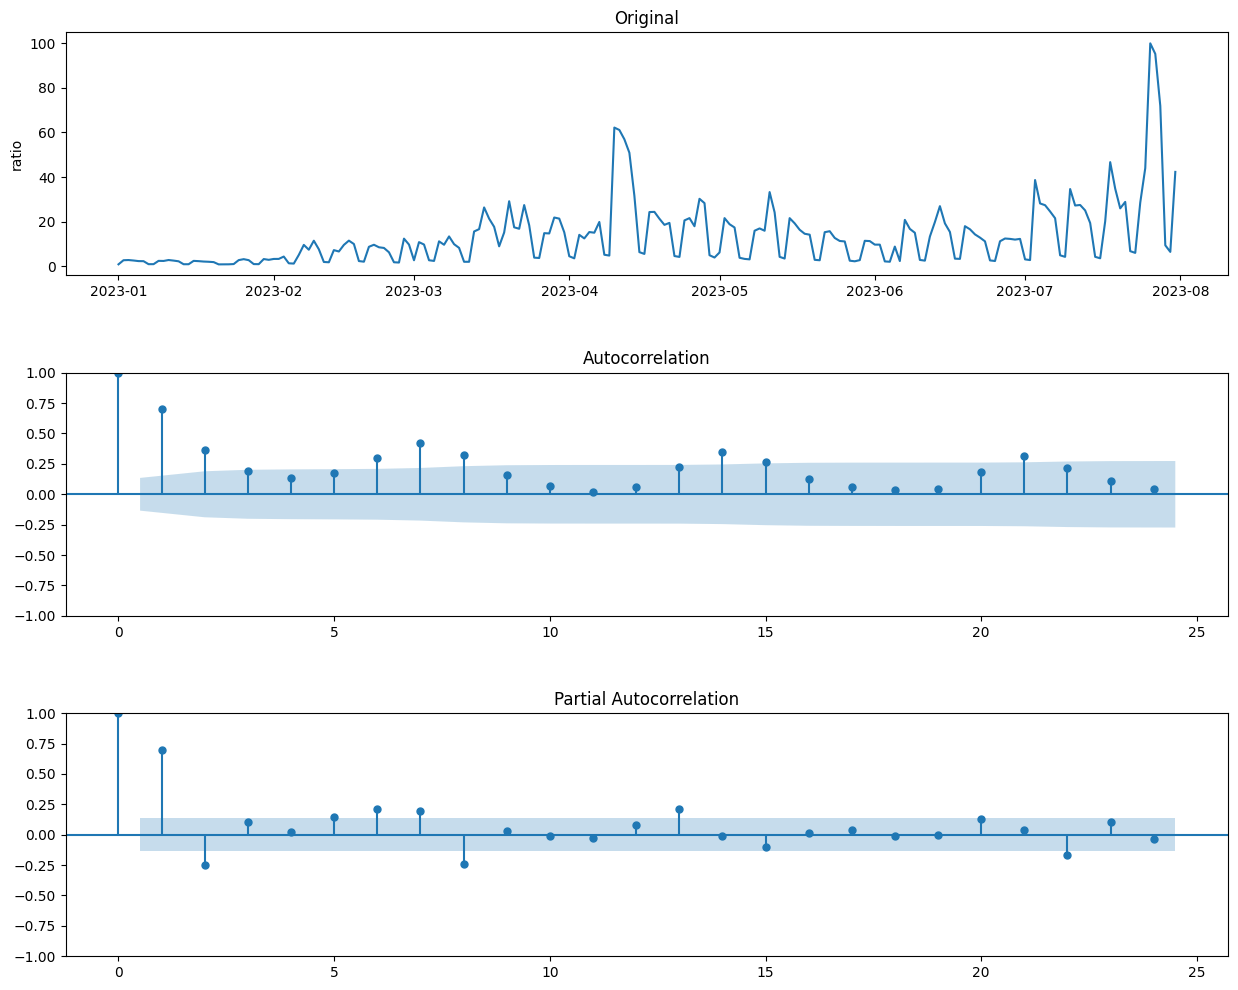

In [11]:
exp_time_data(df2, 'ratio', "m")


In [12]:
diff  = df2.diff()

In [13]:
ar = adfuller(diff2)
print("ADF statistics: %f" % ar[0])
print('p-value: %f' % ar[1])
print('number of lags: %d' % ar[2])
print("number of observations: %d" % ar[3])
print("Critical Values: %f" % ar[5])
for key, value in ar[4].items():
    print('\t%s: %.3f' %(key, value))

NameError: name 'adfuller' is not defined

In [ ]:
model = ARIMA(df2['ratio'], order=(2,1,2), seasonal_order=(2,1,2,7))
fit = model.fit()
print(fit.summary())

                                    SARIMAX Results                                    
Dep. Variable:                           ratio   No. Observations:                  212
Model:             ARIMA(2, 1, 2)x(2, 1, 2, 7)   Log Likelihood                -717.563
Date:                         Tue, 08 Aug 2023   AIC                           1453.126
Time:                                 12:00:17   BIC                           1482.989
Sample:                             01-01-2023   HQIC                          1465.206
                                  - 07-31-2023                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9451      0.322      2.932      0.003       0.313       1.577
ar.L2         -0.3932      0.203     -1.939      0.052     

In [ ]:
fv = fit.fittedvalues
fv.head()


2023-01-01    0.000000
2023-01-02    0.774031
2023-01-03    2.610672
2023-01-04    2.697464
2023-01-05    2.489360
Freq: D, dtype: float64

In [ ]:
fc = fit.forecast(30)
fc.head()


2023-08-01    54.527029
2023-08-02    67.422063
2023-08-03    62.910385
2023-08-04    54.904808
2023-08-05    28.271574
Freq: D, Name: predicted_mean, dtype: float64

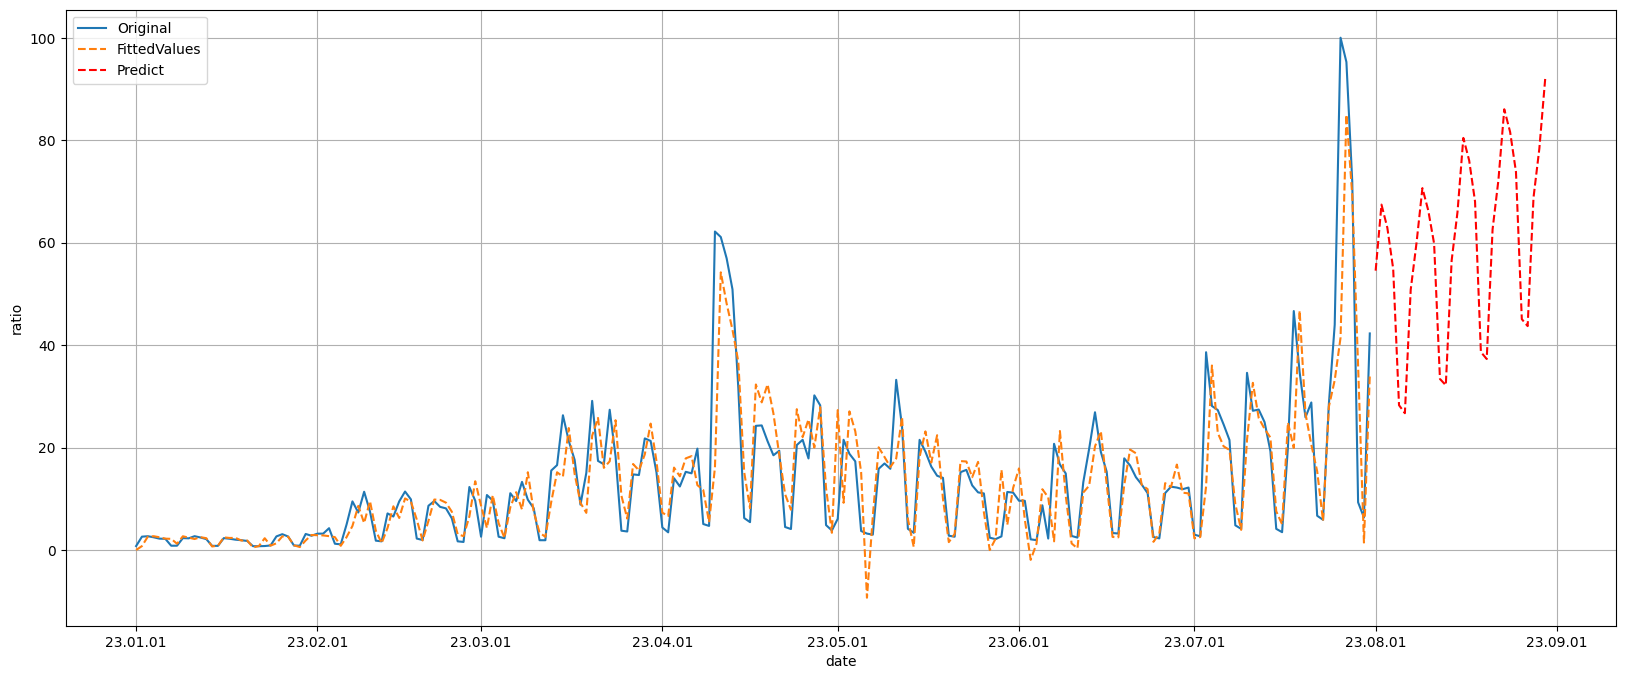

In [ ]:
plt.figure(figsize=(20,8))

sb.lineplot(data=df2, x=df2.index, y='ratio', label='Original')
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('date')
plt.ylabel('ratio')
plt.legend()

monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()
